# Figure. Functional Annotation

In [1]:
import cPickle
import glob
import os
import random
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pybedtools as pbt
from scipy.stats import fisher_exact
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sms
import tabix
import vcf as pyvcf
import weblogolib as logo

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_functional_annotation_and_power_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

In [3]:
fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis', 'encode_dnase_res.tsv')
dnase_res = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis', 'encode_stem_cell_chip_seq_res.tsv')
tf_res = pd.read_table(fn, index_col=0)
tf_res = tf_res.drop_duplicates(subset=['target'])

fn = os.path.join(ciepy.root, 'output', 'gwas_analysis', 'grasp_counts.tsv')
grasp_counts = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'gwas_analysis', 'grasp_results.tsv')
grasp_res = pd.read_table(fn, index_col=0)
grasp_res['phenotype'] = grasp_res.phenotype.apply(lambda x: x.split(' (')[0])

grasp_counts.index = grasp_res.ix[grasp_counts.index, 'phenotype']
grasp_res.index = grasp_res.phenotype
grasp_res = grasp_res.ix[[x for x in grasp_res.index if 'xpression' not in x]]

In [4]:
fn = os.path.join(ciepy.root, 'output', 'gtex_analysis', 'plot_data.tsv')
plotd = pd.read_table(fn, index_col=0)
plotd = plotd.drop('Testis')
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)

## Paper

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/matplotlib/gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


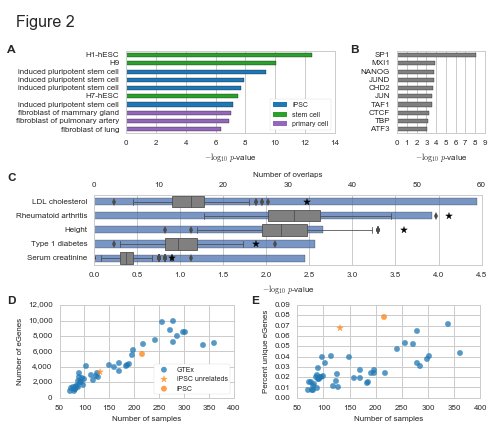

In [5]:
fig = plt.figure(figsize=(6.85, 6.1), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 0, 'Figure 2',
        size=16, va='bottom')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.90, 0.5, 1])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = dnase_res[dnase_res.biosample_type != 'immortalized cell line']
t = dnase_res.ix[t.index].sort_values(by='pvalue', ascending=False).tail(10)
# cdict = dict(zip(set(dnase_res.ix[t.index, 'biosample_type']), sns.color_palette('Set2')))
cdict = dict([['induced pluripotent stem cell line', cpb.analysis.tableau20[0]],
              ['stem cell', cpb.analysis.tableau20[4]],
              ['primary cell', cpb.analysis.tableau20[8]]])
#fig, ax = plt.subplots(1, 1, figsize=(5, 10))
c = [cdict[x] for x in dnase_res.ix[t.index, 'biosample_type']]
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color=c, label=None)
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=8)
#ax.set_title('ENCODE DNase enrichments')
ya, yb = ax.get_ylim()
ax.set_yticklabels(dnase_res.ix[t.index, 'cell_type'], fontsize=8)
rects = []
labels = []
for k in ['induced pluripotent stem cell line', 'stem cell',
          'primary cell',]:
    if k == 'induced pluripotent stem cell line':
        labels.append('iPSC')
    elif k == 'in vitro differentiated cells':
        labels.append('in vitro\ndifferentiated\ncell')
    else:
        labels.append(k)
    r = plt.Rectangle((0, 0), 0, 0, fc=cdict[k])
    rects.append(r)
lgd = ax.legend(rects, labels, loc='lower right', frameon=True, fontsize=7)
#bbox_to_anchor=[0.5, -0.05])#, prop={'size':8}), loc='upper center',
for p in lgd.get_patches():
    p.set_linewidth(0)
ax.grid(axis='y')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
gs.tight_layout(fig, rect=[0, 0.6, 0.7, 0.9])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = tf_res.sort_values(by='pvalue', ascending=False).tail(10)
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color='grey', zorder=2)
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=8)
ya, yb = ax.get_ylim()
t = ax.set_yticklabels(t.target, fontsize=8)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.grid(axis='y')
gs.tight_layout(fig, rect=[0.7, 0.6, 1, 0.9])

gs = gridspec.GridSpec(1, 1)
ax2 = fig.add_subplot(gs[0, 0])

grasp_res.sort_values(by='pvalue', inplace=True)
t = grasp_res[grasp_res.pvalue < 0.05]
t = grasp_res[grasp_res.bh_sig]

ymin = 0
ymax= t.shape[0]

ax2.set_xlabel('$-\log_{10}$ $p$-value', fontsize=8)
h = 0.5
step = abs(ymax - ymin) / t.shape[0]
b = np.arange(ymin, ymax, step) + (step / 2 - h / 2)
ax2.barh(b, -np.log10(grasp_res.ix[t.index, 'pvalue']), height=h, 
         alpha=0.75, zorder=4)

ax = ax2.twiny()

ax = sns.boxplot(data=grasp_counts.ix[t.index, grasp_counts.columns[1:]].T, ax=ax, 
                 orient='h', linewidth=0.8)
boxes = ax.artists
for i,box in enumerate(boxes):
    box.set_facecolor('grey')
ax.scatter(grasp_counts.ix[t.index, 'real'], range(t.shape[0]), s=50, 
           color='black', marker='*', zorder=4)

xmin, xmax = ax.get_xlim()
# for i in range(se.shape[0]):
#     ax.text(0.97 * xmax, i, se.values[i], va='center', ha='center')
ax.set_xlabel('Number of overlaps', fontsize=8)
ax.set_xlim(0, xmax)
ax.set_ylabel('')
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(8)

ymin,ymax = ax.get_ylim()

ax.set_ylim(ymin, ymax)
#ax.set_xlim(0, 50)
# ax2.set_yticklabels(grasp_res.ix[t.index, 'phenotype'], fontsize=8)
# for t in ax.get_xticklabels() + ax.get_yticklabels():
#     t.set_fontsize(8)

ax.grid(axis='x')
ax2.grid(axis='y')
for tick in ax2.get_xticklabels() + ax2.get_yticklabels():
    tick.set_fontsize(8)
gs.tight_layout(fig, rect=[0, 0.3, 1, 0.63])

# Number of eGenes vs. number of samples
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(plotd.ix[plotd.source == 'gtex', 'num_samples'], 
           plotd.ix[plotd.source == 'gtex', 'num_sig_genes'],
           label='GTEx', color=cpb.analysis.tableau20[0], s=30, alpha=0.75)
ax.scatter([plotd.ix['ipsc_unrelateds', 'num_samples']], 
           [plotd.ix['ipsc_unrelateds', 'num_sig_genes']],
           label='iPSC unrelateds', color=cpb.analysis.tableau20[2], alpha=0.75, s=50,
           marker='*')
ax.scatter([plotd.ix['ipsc', 'num_samples']], 
           [plotd.ix['ipsc', 'num_sig_genes']],
           label='iPSC', color=cpb.analysis.tableau20[2], alpha=0.75, s=30)
ax.set_xlabel('Number of samples', fontsize=8)
ax.set_ylabel('Number of eGenes', fontsize=8)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.legend(frameon=True, fancybox=True, fontsize=7, loc='lower right')
ax.yaxis.set_major_formatter(ciepy.comma_format)
gs.tight_layout(fig, rect=[0, 0, 0.5, 0.33])

# Percent distinct eGenes
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(plotd.ix[plotd.source == 'gtex', 'num_samples'], 
           plotd.ix[plotd.source == 'gtex', 'percent_distinct_egenes'],
           label='GTEx', color=cpb.analysis.tableau20[0], s=30, alpha=0.75)
ax.scatter([plotd.ix['ipsc_unrelateds', 'num_samples']], 
           [plotd.ix['ipsc_unrelateds', 'percent_distinct_egenes']],
           label='iPSC 131 unrelateds', color=cpb.analysis.tableau20[2], alpha=0.75, s=50,
           marker='*')
ax.scatter([plotd.ix['ipsc', 'num_samples']], 
           [plotd.ix['ipsc', 'percent_distinct_egenes']],
           label='iPSC', color=cpb.analysis.tableau20[2], alpha=0.75, s=30)
ax.set_xlabel('Number of samples', fontsize=8)
ax.set_ylabel('Percent unique eGenes', fontsize=8)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
#ax.legend(frameon=True, fancybox=True, fontsize=7, loc='upper right')
ymin,ymax = ax.get_ylim()
ax.set_ylim(0, ymax)
gs.tight_layout(fig, rect=[0.5, 0, 1, 0.33])

t = fig.text(0.005, 0.87, 'A', weight='bold', 
             size=12)
t = fig.text(0.7, 0.87, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.58, 'C', weight='bold', 
             size=12)
t = fig.text(0.005, 0.3, 'D', weight='bold', 
             size=12)
t = fig.text(0.5, 0.3, 'E', weight='bold', 
             size=12)

fig.savefig(os.path.join(outdir, 'functional_annotation_power.pdf'))

## Presentation

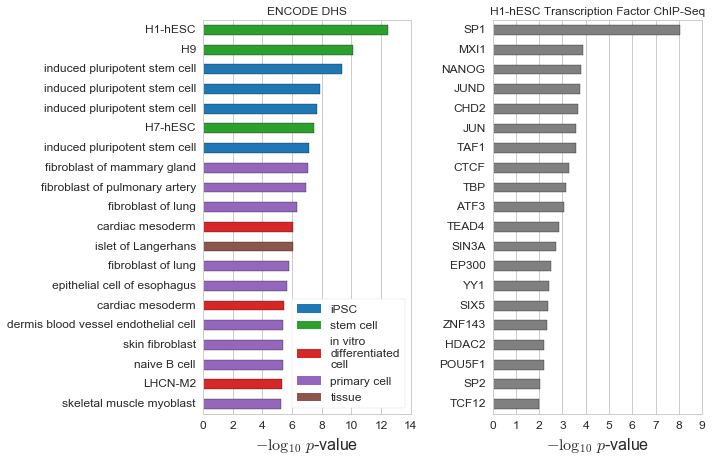

In [6]:
fig = plt.figure(figsize=(10, 6.5), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = dnase_res[dnase_res.biosample_type != 'immortalized cell line']
t = dnase_res.ix[t.index].sort_values(by='pvalue', ascending=False).tail(20)
# cdict = dict(zip(set(dnase_res.ix[t.index, 'biosample_type']), sns.color_palette('Set2')))
cdict = dict([['induced pluripotent stem cell line', cpb.analysis.tableau20[0]],
              ['stem cell', cpb.analysis.tableau20[4]],
              ['in vitro differentiated cells', cpb.analysis.tableau20[6]],
              ['primary cell', cpb.analysis.tableau20[8]], 
              ['tissue', cpb.analysis.tableau20[10]]])
#fig, ax = plt.subplots(1, 1, figsize=(5, 10))
c = [cdict[x] for x in dnase_res.ix[t.index, 'biosample_type']]
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color=c, label=None)
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=16)
#ax.set_title('ENCODE DNase enrichments')
ya, yb = ax.get_ylim()
ax.set_yticklabels(dnase_res.ix[t.index, 'cell_type'], fontsize=8)
rects = []
labels = []
for k in ['induced pluripotent stem cell line', 'stem cell',
          'in vitro differentiated cells', 'primary cell', 'tissue']:
    if k == 'induced pluripotent stem cell line':
        labels.append('iPSC')
    elif k == 'in vitro differentiated cells':
        labels.append('in vitro\ndifferentiated\ncell')
    else:
        labels.append(k)
    r = plt.Rectangle((0, 0), 0, 0, fc=cdict[k])
    rects.append(r)
lgd = ax.legend(rects, labels, loc='lower right', frameon=True, fontsize=12)
#bbox_to_anchor=[0.5, -0.05])#, prop={'size':8}), loc='upper center',
for p in lgd.get_patches():
    p.set_linewidth(0)
ax.grid(axis='y')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(12)
ax.set_title('ENCODE DHS')
gs.tight_layout(fig, rect=[0, 0, 0.6, 1])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = tf_res.sort_values(by='pvalue', ascending=False).tail(20)
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color='grey')
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=16)
ya, yb = ax.get_ylim()
t = ax.set_yticklabels(t.target, fontsize=8)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(12)
ax.grid(axis='y')
ax.set_title('H1-hESC Transcription Factor ChIP-Seq')
gs.tight_layout(fig, rect=[0.6, 0, 1, 1])

fig.savefig(os.path.join(outdir, 'dnase_tf_presentation.pdf'))

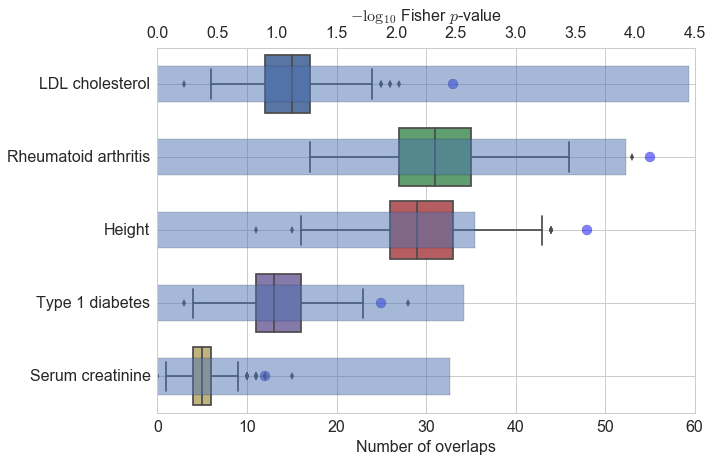

In [7]:
fig,ax = plt.subplots(1, 1, figsize=(10, 6.5), dpi=300)

grasp_res.sort_values(by='pvalue', inplace=True)
t = grasp_res[grasp_res.bh_sig]

sns.boxplot(data=grasp_counts.ix[t.index, grasp_counts.columns[1:]].T, ax=ax, orient='h')
ax.scatter(grasp_counts.ix[t.index, 'real'], range(t.shape[0]), alpha=0.5, s=100)

xmin, xmax = ax.get_xlim()
# for i in range(se.shape[0]):
#     ax.text(0.97 * xmax, i, se.values[i], va='center', ha='center')
ax.set_xlabel('Number of overlaps', fontsize=16)
ax.set_xlim(0, xmax)
ax.set_ylabel('')
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(16)

ymin,ymax = ax.get_ylim()
ax2 = ax.twiny()
ax2.set_xlabel('$-\log_{10}$ Fisher $p$-value', fontsize=16)
h = 0.5
step = abs(ymax - ymin) / t.shape[0]
b = np.arange(ymax, ymin, step) + (step / 2 - h / 2)
ax2.barh(b, -np.log10(grasp_res.ix[t.index, 'pvalue']), height=h, alpha=0.5)
ax.set_ylim(ymin, ymax)
#ax.set_xlim(0, 50)
ax.grid(axis='x')
ax2.grid(axis='x')
ax.grid('x', zorder=4)
for tick in ax2.get_xticklabels() + ax2.get_yticklabels():
    tick.set_fontsize(16)
    
fig.tight_layout()

fig.savefig(os.path.join(outdir, 'gwas_presentation.pdf'))

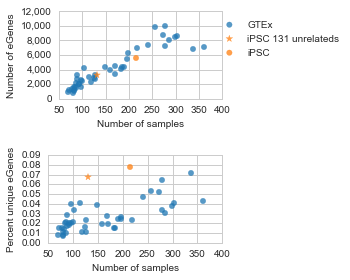

In [8]:
fs = 10

fig = plt.figure(figsize=(6.8, 4), dpi=300)

# Number of eGenes vs. number of samples
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(plotd.ix[plotd.source == 'gtex', 'num_samples'], 
           plotd.ix[plotd.source == 'gtex', 'num_sig_genes'],
           label='GTEx', color=cpb.analysis.tableau20[0], s=30, alpha=0.75)
ax.scatter([plotd.ix['ipsc_unrelateds', 'num_samples']], 
           [plotd.ix['ipsc_unrelateds', 'num_sig_genes']],
           label='iPSC 131 unrelateds', color=cpb.analysis.tableau20[2], alpha=0.75, s=50,
           marker='*')
ax.scatter([plotd.ix['ipsc', 'num_samples']], 
           [plotd.ix['ipsc', 'num_sig_genes']],
           label='iPSC', color=cpb.analysis.tableau20[2], alpha=0.75, s=30)
ax.set_xlabel('Number of samples', fontsize=fs)
ax.set_ylabel('Number of eGenes', fontsize=fs)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
lgd = ax.legend(loc='upper center', bbox_to_anchor=(1.35, 1))
ax.yaxis.set_major_formatter(ciepy.comma_format)
gs.tight_layout(fig, rect=[0, 0.5, 0.5, 1])

# Percent distinct eGenes
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(plotd.ix[plotd.source == 'gtex', 'num_samples'], 
           plotd.ix[plotd.source == 'gtex', 'percent_distinct_egenes'],
           label='GTEx', color=cpb.analysis.tableau20[0], s=30, alpha=0.75)
ax.scatter([plotd.ix['ipsc_unrelateds', 'num_samples']], 
           [plotd.ix['ipsc_unrelateds', 'percent_distinct_egenes']],
           label='iPSC 131 unrelateds', color=cpb.analysis.tableau20[2], alpha=0.75, s=50,
           marker='*')
ax.scatter([plotd.ix['ipsc', 'num_samples']], 
           [plotd.ix['ipsc', 'percent_distinct_egenes']],
           label='iPSC', color=cpb.analysis.tableau20[2], alpha=0.75, s=30)
ax.set_xlabel('Number of samples', fontsize=fs)
ax.set_ylabel('Percent unique eGenes', fontsize=fs)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
#ax.legend(frameon=True, fancybox=True, fontsize=fs, loc='upper right')
ymin,ymax = ax.get_ylim()
ax.set_ylim(0, ymax)
gs.tight_layout(fig, rect=[0, 0, 0.5, 0.5])

fig.savefig(os.path.join(outdir, 'power_presentation.pdf'))